# MNIST
- MNIST: 手書き数字を読み取るタスク
- タスクはクラス識別に分類できる
- 0~9までの数字（ラベル）があるため、10種類のクラスの中から一つのクラスを予測する

## 1. Importと定数定義

In [1]:
import torch
from torchvision import transforms, datasets
from torchvision.models.resnet import BasicBlock
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import wandb
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
BATCH_SIZE = 512
LR = 1e-3
NUM_WORKERS = 4
EPOCHS = 80

## 2. Datasetsを読み込む

In [3]:
# 学習用データセット
train_datasets = datasets.CIFAR10(
    "data/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomAutocontrast(p=0.3),
        transforms.RandomRotation(degrees=45),
        transforms.RandomApply(
            transforms=[
                transforms.ColorJitter(
                    brightness=0.25,
                )
            ],
            p=0.15,
        ),
        transforms.Normalize(
            mean=[0] * 3,
            std=[1] * 3,
        ),
    ])
)
# 検証用データセット
val_datasets = datasets.CIFAR10(
    "data/",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0] * 3,
            std=[1] * 3,
        ),
    ])
)

Files already downloaded and verified
Files already downloaded and verified


## 3. Modelの用意

In [28]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)             
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.pooling1 = nn.MaxPool2d((3, 3), stride=2, padding=1)
        self.layer1 = BasicBlock(
            64,
            64,
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            BasicBlock(
                128,
                128,
            ),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            BasicBlock(
                256,
                256,
            ),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            BasicBlock(
                512,
                512
            ),
        )
        self.fc = nn.Linear(
            512,
            10
        )
        self.activation = nn.LogSoftmax(dim=1)
        
    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = self.pooling1(x)
        x = self.layer1(x)
        x = self.layer2(x)        
        x = self.layer3(x)
        x = self.layer4(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        out = self.activation(x)
        return out

### ネットワークの確認（任意）
今回MNISTは28×28pxなので同様の形状でネットワークに入力をして、出力が(BATCH_SIZE, 10)の形状のテンソルであることを確認する

In [29]:
input_image, input_label = val_datasets[40]
input_image.shape

torch.Size([3, 32, 32])

In [30]:
input_label = torch.tensor([input_label])

In [31]:
imgs = input_image.unsqueeze(dim=0)
labels = input_label.unsqueeze(dim=0)
model = Model()
outs = model(imgs)
outs

tensor([[-2.5091, -2.2860, -2.3170, -2.5485, -2.1882, -2.2469, -2.0481, -2.2395,
         -2.0866, -2.7683]], grad_fn=<LogSoftmaxBackward0>)

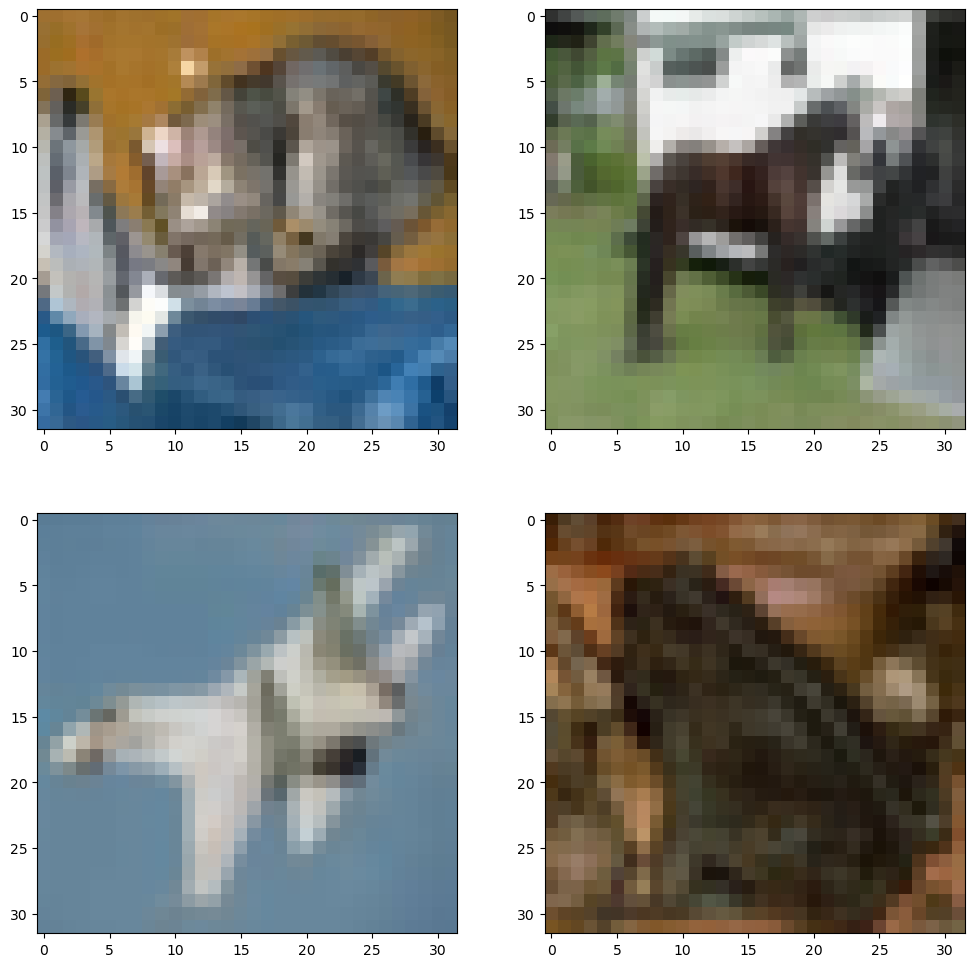

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i in range(2):
    for j in range(2):
        axes[i][j].imshow(val_datasets[10 * (i + j * 2)][0].permute(1, 2, 0).numpy())

## 4.学習 & 検証

### 学習に必要な要素の準備

In [33]:
# デバイス
device = torch.device("cuda")

# 深層学習モデル
model = Model()
model = nn.DataParallel(model)
model = model.to(device)

# 損失関数
loss_fn = nn.NLLLoss() # nn.LogSoftmax + nn.NLLLoss == 交差クロスエントロピー

# 最適化関数
optimizer = optim.Adam(model.parameters(), lr=LR)

# 学習率スケジューラ
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=LR * 0.01,
)

# データローダ
# 学習用
train_dataloader = DataLoader(
    train_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
# 検証用
val_dataloader = DataLoader(
    val_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

### 学習 & 検証

In [34]:
results = [
    {
        "train": {},
        "val": {}
    } for i in range(EPOCHS)
]

In [35]:
for epoch in tqdm(range(EPOCHS)):
    model.train()
    epoch_loss = 0
    correct_counts = 0
    for imgs, labels in tqdm(train_dataloader, leave=False):        
        optimizer.zero_grad()
        imgs = imgs.to(device)
        labels = labels.to(device)
        outs = model(imgs)
        loss = loss_fn(outs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()    
        preds = torch.argmax(outs, dim=1)
        correct_counts += (preds == labels).sum().item()
    lr_scheduler.step()
    acc = correct_counts / len(train_datasets)
    print(f"epoch: {epoch}, train loss: {epoch_loss:.3f}. train acc: {acc:.3f}")
    results[epoch]["train"]["acc"] = acc
    results[epoch]["train"]["loss"] = epoch_loss
    with torch.no_grad():
        model.eval()
        correct_counts = 0
        for imgs, labels in tqdm(val_dataloader, leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outs = model(imgs)
            preds = torch.argmax(outs, dim=1)
            correct_counts += (preds == labels).sum().item()
        acc = correct_counts / len(val_datasets)
        print(f"epoch: {epoch}, val acc: {acc:.3f}")
        results[epoch]["val"]["acc"] = acc

  0%|          | 0/80 [00:00<?, ?it/s]

epoch: 0, train loss: 179.480. train acc: 0.326


  1%|▏         | 1/80 [00:20<26:51, 20.40s/it]

epoch: 0, val acc: 0.360


epoch: 1, train loss: 151.617. train acc: 0.431


  2%|▎         | 2/80 [00:31<19:03, 14.67s/it]

epoch: 1, val acc: 0.393


epoch: 2, train loss: 138.811. train acc: 0.487


  4%|▍         | 3/80 [00:41<16:28, 12.84s/it]

epoch: 2, val acc: 0.502


epoch: 3, train loss: 130.589. train acc: 0.520


  5%|▌         | 4/80 [00:52<15:10, 11.98s/it]

epoch: 3, val acc: 0.537


epoch: 4, train loss: 122.861. train acc: 0.547


  6%|▋         | 5/80 [01:03<14:25, 11.54s/it]

epoch: 4, val acc: 0.574


epoch: 5, train loss: 117.182. train acc: 0.573


  8%|▊         | 6/80 [01:13<13:52, 11.25s/it]

epoch: 5, val acc: 0.611


epoch: 6, train loss: 112.661. train acc: 0.592


  9%|▉         | 7/80 [01:24<13:28, 11.08s/it]

epoch: 6, val acc: 0.589


epoch: 7, train loss: 107.828. train acc: 0.609


 10%|█         | 8/80 [01:35<13:08, 10.95s/it]

epoch: 7, val acc: 0.567


epoch: 8, train loss: 104.534. train acc: 0.622


 11%|█▏        | 9/80 [01:45<12:51, 10.86s/it]

epoch: 8, val acc: 0.631


epoch: 9, train loss: 100.438. train acc: 0.636


 12%|█▎        | 10/80 [01:56<12:39, 10.84s/it]

epoch: 9, val acc: 0.680


epoch: 10, train loss: 97.529. train acc: 0.648


 14%|█▍        | 11/80 [02:07<12:24, 10.79s/it]

epoch: 10, val acc: 0.618


epoch: 11, train loss: 94.633. train acc: 0.660


 15%|█▌        | 12/80 [02:18<12:11, 10.76s/it]

epoch: 11, val acc: 0.654


epoch: 12, train loss: 92.913. train acc: 0.667


 16%|█▋        | 13/80 [02:28<12:03, 10.79s/it]

epoch: 12, val acc: 0.687


epoch: 13, train loss: 90.395. train acc: 0.677


 18%|█▊        | 14/80 [02:39<11:49, 10.75s/it]

epoch: 13, val acc: 0.676


epoch: 14, train loss: 88.441. train acc: 0.684


 19%|█▉        | 15/80 [02:50<11:36, 10.71s/it]

epoch: 14, val acc: 0.709


epoch: 15, train loss: 86.570. train acc: 0.691


 20%|██        | 16/80 [03:00<11:24, 10.70s/it]

epoch: 15, val acc: 0.695


epoch: 16, train loss: 84.198. train acc: 0.698


 21%|██▏       | 17/80 [03:11<11:15, 10.72s/it]

epoch: 16, val acc: 0.710


epoch: 17, train loss: 83.328. train acc: 0.700


 22%|██▎       | 18/80 [03:22<11:02, 10.69s/it]

epoch: 17, val acc: 0.695


epoch: 18, train loss: 80.577. train acc: 0.710


 24%|██▍       | 19/80 [03:32<10:52, 10.70s/it]

epoch: 18, val acc: 0.731


epoch: 19, train loss: 79.110. train acc: 0.718


 25%|██▌       | 20/80 [03:43<10:40, 10.68s/it]

epoch: 19, val acc: 0.652


epoch: 20, train loss: 77.701. train acc: 0.722


 26%|██▋       | 21/80 [03:54<10:29, 10.67s/it]

epoch: 20, val acc: 0.712


epoch: 21, train loss: 76.927. train acc: 0.724


 28%|██▊       | 22/80 [04:04<10:18, 10.67s/it]

epoch: 21, val acc: 0.720


epoch: 22, train loss: 75.226. train acc: 0.730


 29%|██▉       | 23/80 [04:15<10:07, 10.67s/it]

epoch: 22, val acc: 0.729


epoch: 23, train loss: 75.066. train acc: 0.731


 30%|███       | 24/80 [04:26<09:56, 10.66s/it]

epoch: 23, val acc: 0.692


epoch: 24, train loss: 71.990. train acc: 0.742


 31%|███▏      | 25/80 [04:36<09:46, 10.67s/it]

epoch: 24, val acc: 0.753


epoch: 25, train loss: 71.777. train acc: 0.742


 32%|███▎      | 26/80 [04:47<09:35, 10.66s/it]

epoch: 25, val acc: 0.743


epoch: 26, train loss: 70.369. train acc: 0.746


 34%|███▍      | 27/80 [04:58<09:25, 10.66s/it]

epoch: 26, val acc: 0.760


epoch: 27, train loss: 68.321. train acc: 0.756


 35%|███▌      | 28/80 [05:09<09:17, 10.72s/it]

epoch: 27, val acc: 0.758


epoch: 28, train loss: 68.450. train acc: 0.754


 36%|███▋      | 29/80 [05:19<09:04, 10.69s/it]

epoch: 28, val acc: 0.753


epoch: 29, train loss: 66.946. train acc: 0.759


 38%|███▊      | 30/80 [05:30<08:54, 10.69s/it]

epoch: 29, val acc: 0.754


epoch: 30, train loss: 66.022. train acc: 0.764


 39%|███▉      | 31/80 [05:41<08:44, 10.69s/it]

epoch: 30, val acc: 0.719


epoch: 31, train loss: 64.390. train acc: 0.769


 40%|████      | 32/80 [05:51<08:32, 10.67s/it]

epoch: 31, val acc: 0.765


epoch: 32, train loss: 64.574. train acc: 0.767


 41%|████▏     | 33/80 [06:02<08:22, 10.68s/it]

epoch: 32, val acc: 0.747


epoch: 33, train loss: 63.767. train acc: 0.772


 42%|████▎     | 34/80 [06:13<08:11, 10.69s/it]

epoch: 33, val acc: 0.778


epoch: 34, train loss: 61.377. train acc: 0.780


 44%|████▍     | 35/80 [06:23<07:58, 10.64s/it]

epoch: 34, val acc: 0.766


epoch: 35, train loss: 61.156. train acc: 0.780


 45%|████▌     | 36/80 [06:34<07:49, 10.66s/it]

epoch: 35, val acc: 0.767


epoch: 36, train loss: 59.984. train acc: 0.786


 46%|████▋     | 37/80 [06:45<07:38, 10.66s/it]

epoch: 36, val acc: 0.784


epoch: 37, train loss: 59.146. train acc: 0.790


 48%|████▊     | 38/80 [06:55<07:28, 10.68s/it]

epoch: 37, val acc: 0.777


epoch: 38, train loss: 58.221. train acc: 0.791


 49%|████▉     | 39/80 [07:06<07:20, 10.75s/it]

epoch: 38, val acc: 0.794


epoch: 39, train loss: 56.948. train acc: 0.798


 50%|█████     | 40/80 [07:17<07:09, 10.73s/it]

epoch: 39, val acc: 0.804


epoch: 40, train loss: 56.825. train acc: 0.797


 51%|█████▏    | 41/80 [07:27<06:57, 10.70s/it]

epoch: 40, val acc: 0.762


epoch: 41, train loss: 56.037. train acc: 0.797


 52%|█████▎    | 42/80 [07:38<06:46, 10.69s/it]

epoch: 41, val acc: 0.809


epoch: 42, train loss: 55.284. train acc: 0.803


 54%|█████▍    | 43/80 [07:49<06:34, 10.66s/it]

epoch: 42, val acc: 0.742


epoch: 43, train loss: 54.260. train acc: 0.806


 55%|█████▌    | 44/80 [07:59<06:24, 10.67s/it]

epoch: 43, val acc: 0.805


epoch: 44, train loss: 53.802. train acc: 0.808


 56%|█████▋    | 45/80 [08:10<06:12, 10.65s/it]

epoch: 44, val acc: 0.806


epoch: 45, train loss: 53.132. train acc: 0.811


 57%|█████▊    | 46/80 [08:21<06:01, 10.62s/it]

epoch: 45, val acc: 0.808


epoch: 46, train loss: 51.977. train acc: 0.813


 59%|█████▉    | 47/80 [08:31<05:50, 10.63s/it]

epoch: 46, val acc: 0.799


epoch: 47, train loss: 51.370. train acc: 0.815


 60%|██████    | 48/80 [08:42<05:41, 10.67s/it]

epoch: 47, val acc: 0.817


epoch: 48, train loss: 50.541. train acc: 0.819


 61%|██████▏   | 49/80 [08:53<05:30, 10.65s/it]

epoch: 48, val acc: 0.803


epoch: 49, train loss: 49.673. train acc: 0.822


 62%|██████▎   | 50/80 [09:03<05:19, 10.64s/it]

epoch: 49, val acc: 0.806


epoch: 50, train loss: 49.178. train acc: 0.823


 64%|██████▍   | 51/80 [09:14<05:09, 10.66s/it]

epoch: 50, val acc: 0.807


epoch: 51, train loss: 48.367. train acc: 0.826


 65%|██████▌   | 52/80 [09:25<04:58, 10.67s/it]

epoch: 51, val acc: 0.812


epoch: 52, train loss: 47.696. train acc: 0.832


 66%|██████▋   | 53/80 [09:35<04:47, 10.66s/it]

epoch: 52, val acc: 0.815


epoch: 53, train loss: 47.080. train acc: 0.832


 68%|██████▊   | 54/80 [09:46<04:38, 10.72s/it]

epoch: 53, val acc: 0.816


epoch: 54, train loss: 46.021. train acc: 0.836


 69%|██████▉   | 55/80 [09:57<04:27, 10.68s/it]

epoch: 54, val acc: 0.825


epoch: 55, train loss: 45.795. train acc: 0.835


 70%|███████   | 56/80 [10:07<04:15, 10.67s/it]

epoch: 55, val acc: 0.811


epoch: 56, train loss: 45.042. train acc: 0.838


 71%|███████▏  | 57/80 [10:18<04:06, 10.70s/it]

epoch: 56, val acc: 0.816


epoch: 57, train loss: 44.546. train acc: 0.839


 72%|███████▎  | 58/80 [10:29<03:55, 10.71s/it]

epoch: 57, val acc: 0.830


epoch: 58, train loss: 44.088. train acc: 0.842


 74%|███████▍  | 59/80 [10:39<03:44, 10.69s/it]

epoch: 58, val acc: 0.829


epoch: 59, train loss: 42.973. train acc: 0.846


 75%|███████▌  | 60/80 [10:50<03:33, 10.68s/it]

epoch: 59, val acc: 0.827


epoch: 60, train loss: 42.388. train acc: 0.849


 76%|███████▋  | 61/80 [11:01<03:22, 10.68s/it]

epoch: 60, val acc: 0.828


epoch: 61, train loss: 42.126. train acc: 0.847


 78%|███████▊  | 62/80 [11:11<03:11, 10.66s/it]

epoch: 61, val acc: 0.826


epoch: 62, train loss: 41.261. train acc: 0.851


 79%|███████▉  | 63/80 [11:22<03:01, 10.66s/it]

epoch: 62, val acc: 0.827


epoch: 63, train loss: 41.127. train acc: 0.852


 80%|████████  | 64/80 [11:33<02:50, 10.66s/it]

epoch: 63, val acc: 0.834


epoch: 64, train loss: 40.309. train acc: 0.856


 81%|████████▏ | 65/80 [11:43<02:40, 10.67s/it]

epoch: 64, val acc: 0.828


epoch: 65, train loss: 40.218. train acc: 0.856


 82%|████████▎ | 66/80 [11:54<02:29, 10.69s/it]

epoch: 65, val acc: 0.834


epoch: 66, train loss: 39.610. train acc: 0.857


 84%|████████▍ | 67/80 [12:05<02:19, 10.69s/it]

epoch: 66, val acc: 0.829


epoch: 67, train loss: 39.797. train acc: 0.859


 85%|████████▌ | 68/80 [12:16<02:08, 10.69s/it]

epoch: 67, val acc: 0.834


epoch: 68, train loss: 39.173. train acc: 0.859


 86%|████████▋ | 69/80 [12:26<01:57, 10.69s/it]

epoch: 68, val acc: 0.829


epoch: 69, train loss: 38.227. train acc: 0.864


 88%|████████▊ | 70/80 [12:37<01:46, 10.68s/it]

epoch: 69, val acc: 0.833


epoch: 70, train loss: 38.124. train acc: 0.864


 89%|████████▉ | 71/80 [12:48<01:36, 10.68s/it]

epoch: 70, val acc: 0.836


epoch: 71, train loss: 38.383. train acc: 0.862


 90%|█████████ | 72/80 [12:58<01:25, 10.66s/it]

epoch: 71, val acc: 0.837


epoch: 72, train loss: 37.949. train acc: 0.862


 91%|█████████▏| 73/80 [13:09<01:14, 10.68s/it]

epoch: 72, val acc: 0.833


epoch: 73, train loss: 37.474. train acc: 0.867


 92%|█████████▎| 74/80 [13:20<01:04, 10.69s/it]

epoch: 73, val acc: 0.834


epoch: 74, train loss: 37.615. train acc: 0.864


 94%|█████████▍| 75/80 [13:30<00:53, 10.69s/it]

epoch: 74, val acc: 0.835


epoch: 75, train loss: 37.247. train acc: 0.868


 95%|█████████▌| 76/80 [13:41<00:42, 10.67s/it]

epoch: 75, val acc: 0.835


epoch: 76, train loss: 37.167. train acc: 0.867


 96%|█████████▋| 77/80 [13:52<00:32, 10.68s/it]

epoch: 76, val acc: 0.837


epoch: 77, train loss: 37.306. train acc: 0.867


 98%|█████████▊| 78/80 [14:02<00:21, 10.66s/it]

epoch: 77, val acc: 0.835


epoch: 78, train loss: 36.739. train acc: 0.867


 99%|█████████▉| 79/80 [14:13<00:10, 10.76s/it]

epoch: 78, val acc: 0.836


epoch: 79, train loss: 37.128. train acc: 0.868


100%|██████████| 80/80 [14:24<00:00, 10.80s/it]

epoch: 79, val acc: 0.836


# 5.可視化

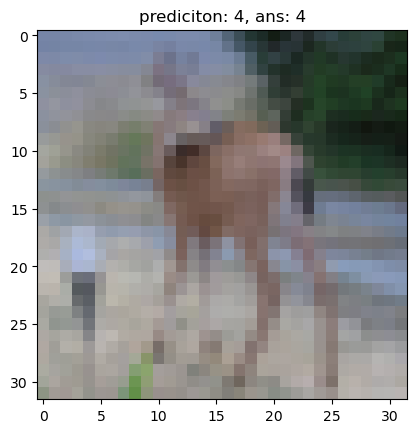

In [36]:
img, label = val_datasets[100]
outs = model(img.unsqueeze(dim=0))

predict_label = torch.argmax(outs, dim=1)[0].item()
img = img.permute((1, 2, 0)).numpy()
plt.imshow(img, cmap="gray")
plt.title(f"prediciton: {predict_label}, ans: {label}")
plt.show()

In [37]:
train_acc = []
train_loss = []
val_acc = []
for result in results:
    train_acc.append(result["train"]["acc"])
    train_loss.append(result["train"]["loss"])
    val_acc.append(result["val"]["acc"])

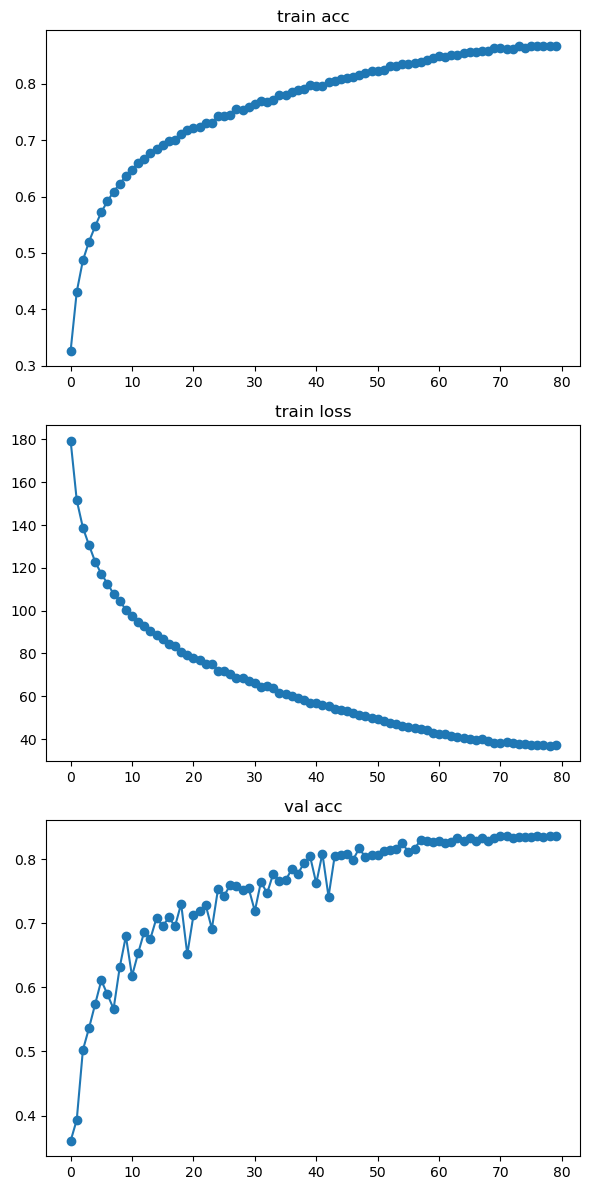

In [38]:
x = np.array(range(EPOCHS))
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

axes[0].plot(x, train_acc, marker="o")
axes[0].set_title("train acc")
axes[1].plot(x, train_loss, marker="o")
axes[1].set_title("train loss")
axes[2].plot(x, val_acc, marker="o")
axes[2].set_title("val acc")
fig.tight_layout()
fig.show()